# Iterate Upon a Model

> Models Available For This Project To Play With Locally

In [ ]:
#| hide
from nbdev.showdoc import *

## Overview 

This example aims to aid a data scientist or MLEs that would like to train their model in a notebook locally and see what the results would be with out sending results to snowflake. Most MLEs and Data Scientist love to experiment and this notebook aims to allow a user to test different model types 

the form of a notebook that does not need to have a full pipeline to wait to be able to see the results or the model artifact. This example aims to show how a DS could quickly iterate and tune their approach rather than going in a pipeline and waiting for results.

There will be a future example in post analysis work, which is extremely fun work, but is currently outside of the goal of this process.

This would mean we would need a new feature set, more thought worthy base query for eligible guest to build upon, and a new call to our dependent variable for BOUGHTPASS to push out to three years. This structure wouldn't need to change to this point and we would quickly iterate to see if we can get a model that can predict that question.

Obviously, there is more to it than that and the post analysis work would be much more rigorous as this would be a net new model not something that has performed well over the past couple of years.


**What we will accomplish**:

1. Pulling data from your experiment data creation.

2. Train your model using one of the models of your choice from your library.

3. Having the ability to use your model locally for your desired way of evaluating.

> There are so many repos inside of [Gitlab Vail Resorts](https://gitlab.com/VailResorts) that have so many different types of analysis approaches that the section on desired way of evaluating that if you need a spark go there and look around in the notebooks there is amazing work there.

> **Warning**: this is a draft to get something out that is something that gets the majority of a project work flow that exists right now 

> **WARINING** To be able to use your scripts you need to install your library so make sure you pip install . in your terminal

## Create Data From data_creation Script

This will create your data for your training set this can take some time depending on your query.

Below is the output of what it would look like if you were to call the data creation 

In [ ]:
# |skip
# ! data_creation  --train_or_inference "TRAINING" --experiment_name "BASELINE"

In [ ]:
# |skip
# ! data_creation  --train_or_inference 'INFERENCE' --experiment_name 'BASELINE'

## Grab Data From Experiment 

In [ ]:
#| skip
from LTBP.data.utils import snowflake_query, get_yaml_dicts

from LTBP.modeling.utils import (
    create_stage_and_query_stage_sf, create_sklearn_preprocess_baseline_dict,
    return_list_of_vars, prepare_training_set, save_sklearn_object_to_data_lake
)

import logging
import os

/Users/jeremydemlow/miniforge3/envs/ltbp/lib/python3.9/site-packages/snowflake/connector/options.py:96: UserWarning: You have an incompatible version of 'pyarrow' installed (6.0.0), please install a version that adheres to: 'pyarrow<8.1.0,>=8.0.0; extra == "pandas"'
  warn_incompatible_dep(


In [ ]:
#| skip
yaml_file_list=['features.yaml', 'udf_inputs.yaml','etl.yaml','models.yaml']
prod_or_dev = 'dev'
experiment_name='BASELINE'
experiment = True # this will trigger if the feature set needs to be created
test_set = True

# Grab all yaml files for current probject
features, udf_inputs, etl_dict, models_dict = get_yaml_dicts(yaml_file_list)

# Create Snowflake Stage and Query Experiment location or commit location and return training data
sf = snowflake_query(sfSchema=prod_or_dev if prod_or_dev.lower() == 'dev' else 'LTBP')
df_train = create_stage_and_query_stage_sf(
    sf=sf,
    etl=etl_dict,
    udf_inputs=udf_inputs,
    train_or_inference='TRAINING',
    experiment_name=experiment_name,
    experiment=experiment,
    indentification=models_dict['identification']
    )
logging.info(f'size of test set {df_train.shape}')
df_train.head(2)

INFO:data_system_utilities.snowflake.utils:stage_query: 
 create or replace stage ltbpFY23LocalRunTest
url='azure://vaildtscadls.blob.core.windows.net/vailadls/projects/LTBP/FY23/experiments/BASELINE'
credentials=(azure_sas_token='**MASKED**')
encryption=(type= 'NONE')
file_format = (type = parquet        )
INFO:data_system_utilities.snowflake.utils:connection to snowflake established...
INFO:data_system_utilities.snowflake.query:executing query
INFO:data_system_utilities.snowflake.query:data loaded from snowflake
INFO:data_system_utilities.snowflake.query:connection to snowflake has been turned off
INFO:data_system_utilities.snowflake.query:Stage area LTBPFY23LOCALRUNTEST successfully created.
INFO:root:adls snowflake stage query 
    select
    $1:"ECID"::varchar as ECID
, $1:"SEASONYEAR"::varchar as SEASONYEAR
, $1:"AGE"::varchar as AGE
, $1:"AVGVISITPERSEASON"::varchar as AVGVISITPERSEASON
, $1:"BOUGHTPASS"::varchar as BOUGHTPASS
, $1:"DESTINATIONGEOAFINITYLABEL"::varchar as DESTIN

,ECID,SEASONYEAR,AGE,AVGVISITPERSEASON,BOUGHTPASS,DESTINATIONGEOAFINITYLABEL,EVERCOREPASS,EVERPASS,GENDERCODE,GUESTBEHAVIOR,...,MOSTVISITEDREGION,MOSTVISITEDRESORT,ONLYSINGLERESORTKEY,PARTNERRESORTSCANNERFLAG,RESORTSVISITED,SKIERABILITYLABEL,SUBSEASONSPERYEAR,TOTALSEASONSSCANNED,TOTALVISITS,VISITMOSTINPEAK
0,57367477,2018/19,60,9.5,1,International,0,1,M,Renewal Multi-Year,...,Pacific Northwest,18,18,0,1,Advanced,3.5,2,19,1
1,66922800,2018/19,47,6.5,0,Unknown,0,0,F,None,...,Pacific Northwest,18,None,0,2,Advanced-Intermediate,1.5,2,13,1


# Preprocess Training Data

In [ ]:
#| skip
from machine_learning_utilities import preprocessing

In [ ]:
#| skip
# Choosing an adls path depending on experiment being true or false
adls_path = os.path.join((os.path.join(etl_dict['data_lake_path'], 'experiments', experiment_name)
    if experiment 
    else os.path.join(etl_dict['data_lake_path'], 
    os.environ.get('CI_COMMIT_SHA', 'LocalRunNBS')))
    , models_dict['preprocessors_adls_path'])

# Grab all Categorical and Continous Variables for Modeling
cat_vars =[{f.upper() : values['transformation'][experiment_name]} for f, values in features.items() 
            if values['var_type'][experiment_name] == 'cat'
            and values['input_definition'] != 'LABEL']
cont_vars =[{f.upper(): values['transformation'][experiment_name]} for f, values in features.items() 
            if values['var_type'][experiment_name] == 'cont'
            and values['input_definition'] != 'LABEL']
y_var=[k.upper() for k, v in features.items() if v['input_definition'] == 'LABEL']

# Create Dictionary and create sklearn preprocessing Pipeline
feature_dict = create_sklearn_preprocess_baseline_dict(cat_vars=cat_vars, 
                                                       cont_vars=cont_vars)
logging.info(feature_dict)
cat_vars = return_list_of_vars(cat_vars)
cont_vars = return_list_of_vars(cont_vars)
logging.info(f"categorical variables: \n {cat_vars}")
logging.info(f"continous variables: \n {cont_vars}")
pipe = preprocessing.generate_sklearn_preprocessing_pipeline(
    feature_dict, impute=True, impute_strategy='mean'
)


# Preprocess and split data set to return neccessary object for modeling
result = prepare_training_set(df_train,
                              y_var=[k.upper() for k, v in features.items() if v['input_definition'] == 'LABEL'],
                              y_scaler_type=models_dict[experiment_name]['y_scaler_type'],
                              adls_path=adls_path,
                              sklearn_pipe=pipe,
                              test_set=test_set,
                              etl_dict=etl_dict,
                              models_dict=models_dict,
                              connection_str=os.environ[models_dict["connection_str"]],
                              experiment_name=experiment_name,
                              as_type=int,
                              identifiers=['ECID', 'SEASONYEAR']
                              )
if test_set:
    X_train, X_valid, X_test, y_train, y_valid, y_test, sklearn_pipe, scaler, id_list = result
else:
    X_train, X_valid, y_train, y_valid, sklearn_pipe, scaler, id_list = result

INFO:root:{'DESTINATIONGEOAFINITYLABEL': {'transformation': {'name': 'OrdinalEncoder', 'args': {'handle_unknown': 'use_encoded_value', 'unknown_value': -1}}, 'variable_type': 'cat'}, 'EVERCOREPASS': {'transformation': {'name': 'OrdinalEncoder', 'args': {'handle_unknown': 'use_encoded_value', 'unknown_value': -1}}, 'variable_type': 'cat'}, 'EVERPASS': {'transformation': {'name': 'OrdinalEncoder', 'args': {'handle_unknown': 'use_encoded_value', 'unknown_value': -1}}, 'variable_type': 'cat'}, 'GENDERCODE': {'transformation': {'name': 'OrdinalEncoder', 'args': {'handle_unknown': 'use_encoded_value', 'unknown_value': -1}}, 'variable_type': 'cat'}, 'GUESTBEHAVIOR': {'transformation': {'name': 'OrdinalEncoder', 'args': {'handle_unknown': 'use_encoded_value', 'unknown_value': -1}}, 'variable_type': 'cat'}, 'ISEPICMIXACTIVATED': {'transformation': {'name': 'OrdinalEncoder', 'args': {'handle_unknown': 'use_encoded_value', 'unknown_value': -1}}, 'variable_type': 'cat'}, 'MARKETINGZONE': {'transfo

INFO:root:Successfully Spilt Data
Train: (24000, 24), (24000, 1)
Valid: (5100, 24), (5100, 1)
Test: (900, 24), (900, 1)
INFO:root:Size of the id_list for the hold set (900, 2)
INFO:root:This project relies on the query to have accurate labels with no preprocessing..
INFO:root:Pushing Sklearn Object to Azure: projects/LTBP/FY23/experiments/BASELINE/preprocessors/LocalRunTeststandard_pipe.pickle
INFO:data_system_utilities.azure.storage:Uploading LocalRunTeststandard_pipe.pickle, to Azure Storage projects/LTBP/FY23/experiments/BASELINE/preprocessors/LocalRunTeststandard_pipe.pickle
INFO:data_system_utilities.azure.storage:Azure Upload Complete
INFO:root:LocalRunTeststandard_pipe.pickle successfully pushed to projects/LTBP/FY23/experiments/BASELINE/preprocessors/


## Training Model

In [ ]:
#| skip
import LTBP.modeling.models as ds_models

### How to Change Model In Notebook

This current code will run the model that is expected to run, but feel make the following change to train a logistic regression.

 - *models_dict[experiment_name]['model_trainer']* --> 'train_logistic' 
 
> this simply takes the model from models.py

You could also develop a new model in the notebook and push it out against your data set and see what the results are by running the following code this is just where this notebook is trying add flexibility as the overview stated

```python
import xgboost as xgb


def train_xgb_basic(X_train, X_valid, y_train, y_valid, early_stop=10, verbose=True, **args):
    """
    Binary Classifiation Xgboost Sklearn API Call Basic HyperParameters
    """
    logging.info(f'Training on {X_train.shape[0]} rows')
    model = xgb.XGBClassifier(n_jobs=-1)
    eval_set = [(X_valid, y_valid)]
    model.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=early_stop, verbose=verbose)
    return model
```

### Train Model 

In [ ]:
#| skip
# Choosing model from models.py to use from models.yaml file
model_trainer = getattr(ds_models, models_dict[experiment_name]['model_trainer'])
model = model_trainer(X_train,
                      X_valid,
                      y_train,
                      y_valid,
                      evals=models_dict[experiment_name]['hyperopt_evals'],
                      sub=models_dict[experiment_name]['hyper_opt_subsample_size'],
                      train=models_dict[experiment_name]['training_subsample_size'])

INFO:root:Hyper tuning on 24000 rows


  0%|                        | 0/2 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007781 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 50%|▌| 1/2 [00:06<00:06,  6.09s/trial, best loss: 0.09779853662340

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007526 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.097799


100%|█| 2/2 [00:08<00:00,  4.11s/trial, best loss: 0.09779853662340

INFO:root:Full training on 24000 rows


## Evaluating Model Results

The code below is just a simple function inside of Modeling Utilities Custom Notebook that evaluates the model the way that a user might want to do this is where you would be able to evaluate the model in a custom way or see how the plots look for your model.

An example of this is if you were using prophet for a forecast model you could really benefit from seeing the component plots that come out of that library to be able to make decision on where to investigate next this was very useful in the process for resort visitation forecasting

In [ ]:
#| skip
from LTBP.modeling.custom_utils import evaluate

INFO:root:Training Set Evaluation
INFO:root:Variable(s) of interest ['BOUGHTPASS'] AUC: 0.905    Accuracy: 0.827    Balanced Accuracy: 0.829
INFO:root:Feature Importance df: 
                           COLS     IMP
0                     EVERPASS  0.1590
1         MOSTCOMMONTICKETCOMP  0.0090
2            SUBSEASONSPERYEAR  0.0090
3                  TOTALVISITS  0.0084
4                 EVERCOREPASS  0.0058
5                GUESTBEHAVIOR  0.0054
6   DESTINATIONGEOAFINITYLABEL  0.0050
7          TOTALSEASONSSCANNED  0.0040
8                          AGE  0.0038
9           ISEPICMIXACTIVATED  0.0036
10           MOSTVISITEDRESORT  0.0034
11               MARKETINGZONE  0.0032
12           SKIERABILITYLABEL  0.0026
13         ONLYSINGLERESORTKEY  0.0024
14        MOSTSUBSEASONVISITED  0.0022
15           MOSTVISITEDREGION  0.0022
16           AVGVISITPERSEASON  0.0014
17              RESORTSVISITED  0.0012
18    PARTNERRESORTSCANNERFLAG  0.0000
19             VISITMOSTINPEAK  0.0000
20   

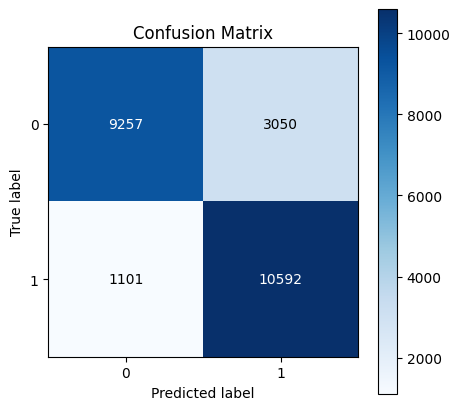

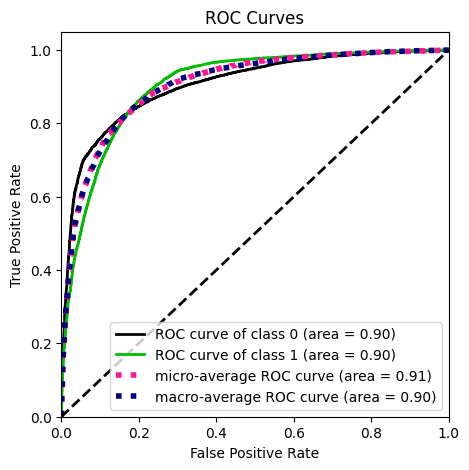

INFO:root:Validation Set Evaluation
INFO:root:Variable(s) of interest ['BOUGHTPASS'] AUC: 0.895    Accuracy: 0.819    Balanced Accuracy: 0.820
INFO:root:Feature Importance df: 
                           COLS     IMP
0                     EVERPASS  0.1598
1                  TOTALVISITS  0.0142
2                 EVERCOREPASS  0.0084
3            SUBSEASONSPERYEAR  0.0062
4         MOSTCOMMONTICKETCOMP  0.0046
5          TOTALSEASONSSCANNED  0.0030
6          ONLYSINGLERESORTKEY  0.0026
7                GUESTBEHAVIOR  0.0024
8   DESTINATIONGEOAFINITYLABEL  0.0022
9            AVGVISITPERSEASON  0.0014
10           MOSTVISITEDREGION  0.0012
11              RESORTSVISITED  0.0010
12        MOSTSUBSEASONVISITED  0.0004
13               MARKETINGZONE  0.0004
14    PARTNERRESORTSCANNERFLAG  0.0000
15             VISITMOSTINPEAK  0.0000
16           SKIERABILITYLABEL -0.0004
17          ISEPICMIXACTIVATED -0.0004
18                  GENDERCODE -0.0010
19                         AGE -0.0012
20 

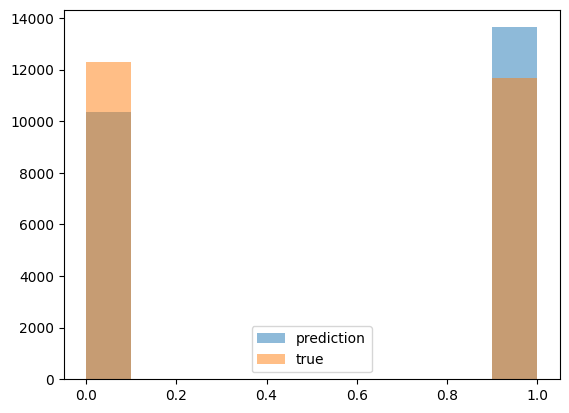

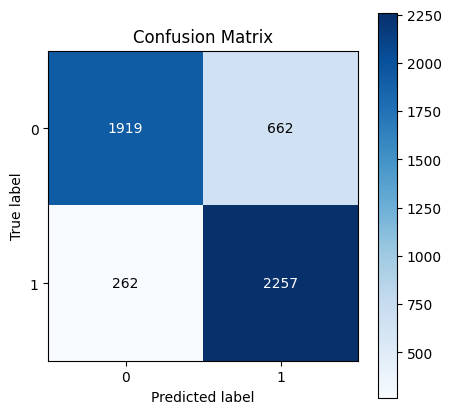

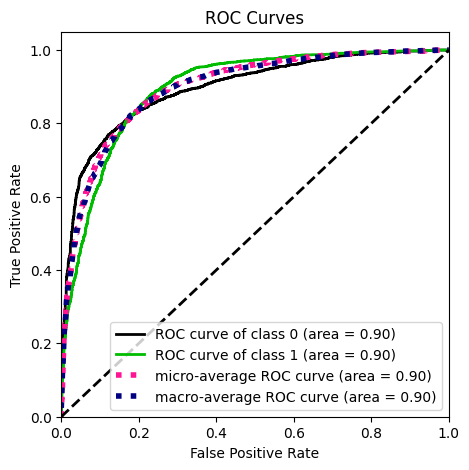

INFO:root:Test Set Evaluation
INFO:root:Variable(s) of interest ['BOUGHTPASS'] AUC: 0.900    Accuracy: 0.829    Balanced Accuracy: 0.834
INFO:root:Feature Importance df: 
                           COLS       IMP
0                     EVERPASS  0.162222
1                  TOTALVISITS  0.020000
2           ISEPICMIXACTIVATED  0.005556
3   DESTINATIONGEOAFINITYLABEL  0.004444
4            MOSTVISITEDREGION  0.002222
5          ONLYSINGLERESORTKEY  0.002222
6            MOSTVISITEDRESORT  0.001111
7         MOSTCOMMONTICKETCOMP  0.001111
8          TOTALSEASONSSCANNED  0.000000
9            SUBSEASONSPERYEAR  0.000000
10              RESORTSVISITED  0.000000
11           AVGVISITPERSEASON  0.000000
12             VISITMOSTINPEAK  0.000000
13    PARTNERRESORTSCANNERFLAG  0.000000
14                EVERCOREPASS  0.000000
15               MARKETINGZONE  0.000000
16                  GENDERCODE -0.001111
17           SKIERABILITYLABEL -0.002222
18        MOSTSUBSEASONVISITED -0.003333
19      

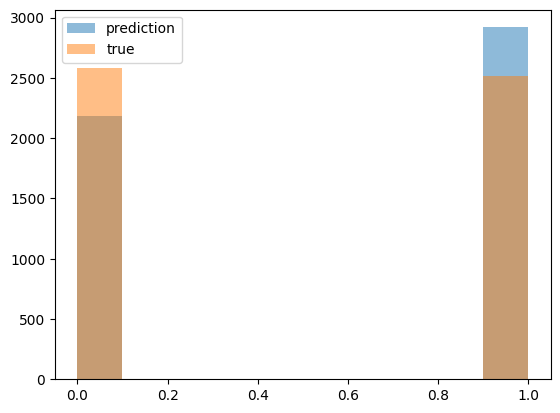

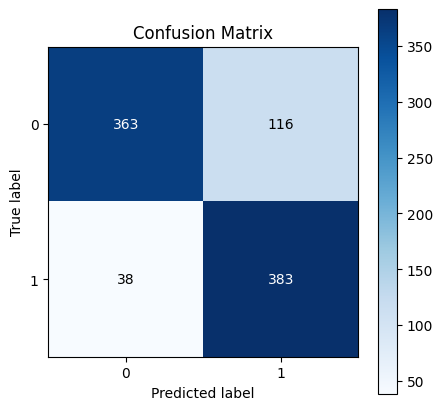

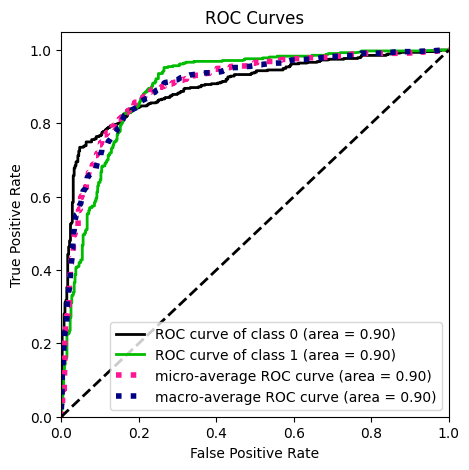

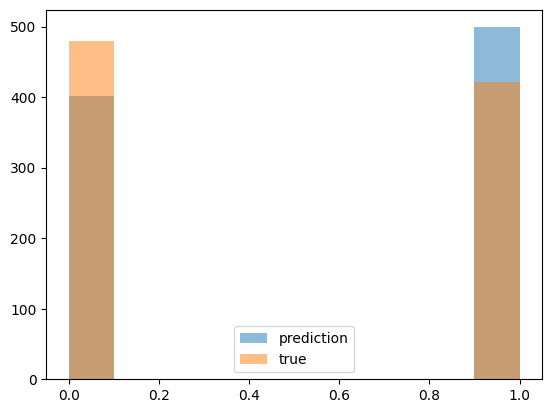

In [ ]:
#| skip
result_dict = {}
logging.info('Training Set Evaluation')

eval_list_train = evaluate(model, X_train, y_train, y_var, feature_importance=True, plot=True)
metric1, metric2, metric3, columns, _, _, fi_permutation = eval_list_train
result_dict['training_metrics']={k: v for k, v in zip(columns, [metric1]+[metric2]+[metric3])}
result_dict['fi_train']={k:v for k, v in fi_permutation[:10].values}
logging.info('Validation Set Evaluation')
eval_list_valid = evaluate(model, X_valid, y_valid, y_var, feature_importance=True, plot=True)
metric1, metric2, metric3, columns, y_pred_proba, y_pred, fi_permutation = eval_list_train
result_dict['valid_metrics']={k: v for k, v in zip(columns, [metric1]+[metric2]+[metric3])}
result_dict['fi_valid']={k:v for k, v in fi_permutation[:10].values}
if X_test is not None:
    logging.info('Test Set Evaluation')
    eval_list_test = evaluate(model, X_test, y_test, y_var, feature_importance=True, plot=True)
    metric1, metric2, metric3, columns, y_pred_proba, y_pred, fi_permutation = eval_list_test
    result_dict['test_metrics']={k: v for k, v in zip(columns, [metric1]+[metric2]+[metric3])}
    result_dict['fi_test']={k:v for k, v in fi_permutation[:10].values}

# Final Remarks

The number of changes and the future of this type of work is really exciting this is purely a POC of what this walk through right now this is here to help the 2022/23 winter work load to move some of our existing models into a template that we can build on.

This a great work in progress notebook that could add SHAP, feature selection processes, so many more things these examples would be where people can come in and look at experiments that the last person did to make sure that they don't go over the same thing or maybe there is just an interest to see it run this would be where it lives

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()